In [1]:
# This notebook is all about really crunnching when we have an image what we would 'like' to be
# called calibrated and not. Basically, what averages will we be happy with, and which will we not.
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
from ese.experiment.metrics import TL_ECE
import torch
import matplotlib.pyplot as plt


# For using code without restarting.
%load_ext autoreload
%autoreload 2

## Example 1: Bad half-boundary.

Text(0.5, 1.0, 'Ground Truth 1')

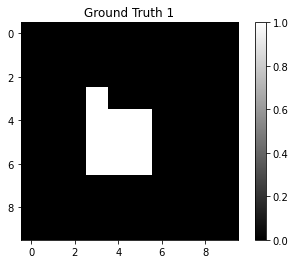

In [2]:
# let's make the ground truth, which is a 10x10 tensor with a white square in the middle
# we will slice off the right side of the square to make our contradiction.
ground_truth1 = torch.zeros(10, 10)
ground_truth1[3:7, 3:7] = 1
ground_truth1[3:7, 6] = 0
ground_truth1[3, 4:7] = 0

plt.imshow(ground_truth1, cmap='gray')  
plt.colorbar()
plt.title('Ground Truth 1')

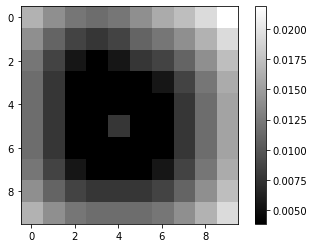

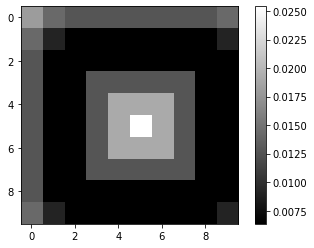

In [16]:
from ese.experiment.losses.weights import dice_weights, hausdorff_weights

test_x = torch.zeros(2, 10, 10)

test_x[0, 3:7, 3:7] = 1
test_x[0, 3:7, 6] = 0
test_x[0, 3, 4:7] = 0

test_x[1, 2:9, 2:9] = 1

# weighted_square = dice_weights(test_x)
weighted_square = hausdorff_weights(test_x)

for b_idx in range(test_x.shape[0]):
    plt.imshow(weighted_square[b_idx], cmap='gray')
    plt.colorbar()
    plt.show()

Text(0.5, 1.0, 'Confidence Map 1')

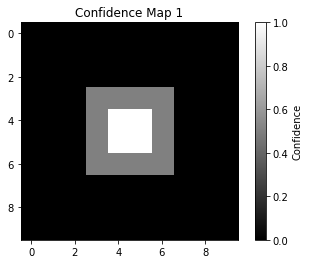

In [4]:
# Let's now make some predictions that we want to break the ECE metric.
# The way we do this is by making predictions in the same bin have wildly different accuracies.
# First we make a confidence map where the boundary of the square is 0.6 and the middle is 0.1
# and the rest if 0
fore_conf_map1= torch.zeros(10, 10)
fore_conf_map1[3:7, 3:7] = 0.5
fore_conf_map1[4:6, 4:6] = 1.0
back_conf_map1 = 1 - fore_conf_map1
chann_conf_map1 = torch.stack([back_conf_map1, fore_conf_map1], dim=0)
# Get the argmax
conf_map1 = torch.max(chann_conf_map1, dim=0).values

plt.imshow(fore_conf_map1, vmin=0, vmax=1, cmap='gray')
plt.colorbar(label="Confidence")
plt.title("Confidence Map 1")

Text(0.5, 1.0, 'Prediction Map 1')

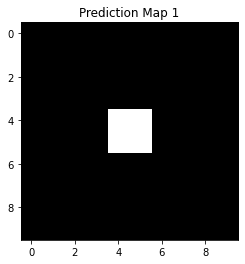

In [5]:
# Now we adversarily make our pred predict exactly half of the 0.5 area correctly (the top left) and the other half incorrectly (the bottom right).
pred_map1 = torch.argmax(chann_conf_map1, dim=0)

plt.imshow(pred_map1, cmap='gray')
plt.title("Prediction Map 1")

Text(0.5, 1.0, 'Confidence Map 1')

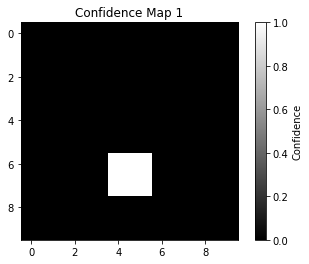

In [6]:
pred_map2 = torch.zeros(10, 10)
pred_map2[6:8, 4:6] = 1.0

plt.imshow(pred_map2, vmin=0, vmax=1, cmap='gray')
plt.colorbar(label="Confidence")
plt.title("Confidence Map 1")

In [7]:
pred_map1= pred_map1[None]

In [8]:
pred_map1.shape

torch.Size([1, 10, 10])

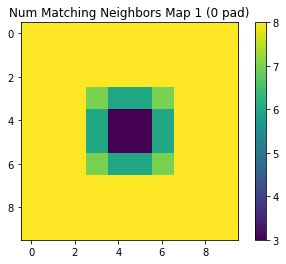

In [9]:
from ese.experiment.metrics.utils import agg_neighbors_preds

num_neighbors_constant_boundary = agg_neighbors_preds(
    pred_map1, 
    neighborhood_width=3,
    class_wise=False,
    discrete=True,
    binary=False
)

plt.imshow(num_neighbors_constant_boundary.squeeze())
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()

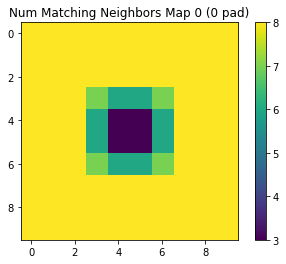

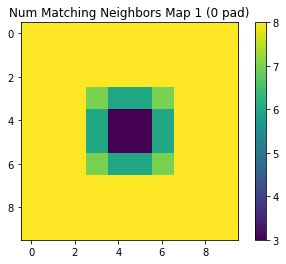

In [10]:
from ese.experiment.metrics.utils import agg_neighbors_preds

num_neighbors_constant_boundary = agg_neighbors_preds(
    pred_map1, 
    neighborhood_width=3,
    class_wise=True,
    num_classes=2,
    discrete=True,
    binary=False
)

plt.imshow(num_neighbors_constant_boundary.squeeze()[0])
plt.title("Num Matching Neighbors Map 0 (0 pad)")
plt.colorbar()
plt.show()
plt.imshow(num_neighbors_constant_boundary.squeeze()[1])
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()
plt.show()

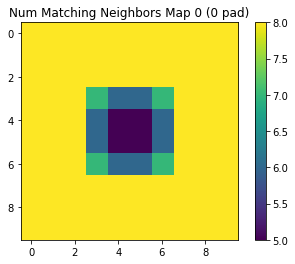

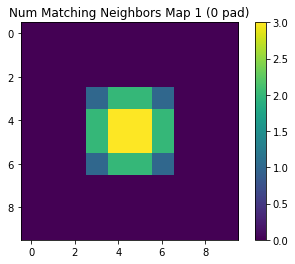

In [11]:
from ese.experiment.metrics.utils import agg_neighbors_preds

num_neighbors_constant_boundary = agg_neighbors_preds(
    pred_map1, 
    neighborhood_width=3,
    num_classes=2,
    class_wise=True,
    discrete=True,
    binary=True
)

plt.imshow(num_neighbors_constant_boundary.squeeze()[0])
plt.title("Num Matching Neighbors Map 0 (0 pad)")
plt.colorbar()
plt.show()
plt.imshow(num_neighbors_constant_boundary.squeeze()[1])
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()
plt.show()

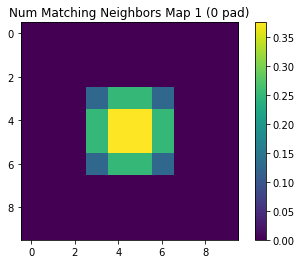

In [12]:
from ese.experiment.metrics.utils import agg_neighbors_preds

num_neighbors_constant_boundary = agg_neighbors_preds(
    pred_map1.float(), 
    neighborhood_width=3,
    class_wise=False,
    discrete=False,
    binary=True
)

plt.imshow(num_neighbors_constant_boundary.squeeze())
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()

In [13]:
from ese.experiment.metrics.utils import count_matching_neighbors

num_neighbors_constant_boundary = count_matching_neighbors(pred_map1[None], neighborhood_width=3, binary=True)

plt.imshow(num_neighbors_constant_boundary.squeeze())
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()

ImportError: cannot import name 'count_matching_neighbors' from 'ese.experiment.metrics.utils' (/storage/vbutoi/projects/ESE/ese/experiment/metrics/utils.py)

In [ ]:
combined = torch.stack([pred_map1, pred_map2], dim=0)
combined = count_matching_neighbors(combined)

plt.imshow(combined[0])
plt.title("Num Matching Neighbors Map 1 (0 pad)")
plt.colorbar()
plt.show()
plt.imshow(combined[1])
plt.title("Num Matching Neighbors Map 2 (0 pad)")
plt.colorbar()
plt.show()

In [ ]:
from ese.experiment.metrics.utils import count_matching_neighbors

num_neighbors = count_matching_neighbors(pred_map1, reflect_boundaries=True)

plt.imshow(num_neighbors)
plt.title("Num Matching Neighbors Map 1 (reflect pad)")
plt.colorbar()

In [ ]:
from ese.experiment.metrics.utils import get_nw_pix_props

pixel_props = get_nw_pix_props(
    pred_map1, 
    num_neighbors_map=num_neighbors
    )

plt.imshow(pixel_props)
plt.title("Pixel Proportions")
plt.colorbar()
plt.show()

In [ ]:
pixel_props.unique()

In [ ]:
assert abs(pixel_props.sum() - 100) < 0.0003, "Weights should sum to 100, got sum = {}".format(pixel_props.sum())

In [ ]:
# Paradoxically, this will have an ECE of 0!
cal_err = TL_ECE(
    num_bins=10,
    pred_map=pred_map1,
    conf_map=conf_map1,
    label_map=ground_truth1
)["cal_score"]
print("ECE: ", cal_err)

### I would actually argue this is a bad adversary because this is what calibration is meant to do, half of the pixels at the border are correct and half are wrong... thus 0.5. But it IS illustrative of a different problem, that is that different parts of the image and somehow compensate for each other. For example, working still with one object, consider the following example.

## Example 2: A Boundary Case ... Literally

In [ ]:
# let's make the ground truth, which is a 10x10 tensor with a white square in the middle
# we will slice off the right side of the square to make our contradiction.
ground_truth2 = torch.zeros(10, 10)
ground_truth2[2:8, 2:8] = 1

plt.imshow(ground_truth2, cmap='gray')  
plt.title('Ground Truth 2')

In [ ]:
# Let's now make some predictions that we want to break the ECE metric.
# The way we do this is by making predictions in the same bin have wildly different accuracies.
# First we make a confidence map where the boundary of the square is 0.6 and the middle is 0.1
# and the rest if 0
fore_conf_map2 = torch.zeros(10, 10)
fore_conf_map2[1:9, 1:9] = 0.5
fore_conf_map2[3:7, 3:7] = 1 
fore_conf_map2[3, 3:7] = 0.5
fore_conf_map2[6, 3:7] = 0.5

back_conf_map2 = 1 - fore_conf_map2
chann_conf_map2 = torch.stack([back_conf_map2, fore_conf_map2], dim=0)
# Get the argmax
conf_map2 = torch.max(chann_conf_map2, dim=0).values

plt.imshow(fore_conf_map2, vmin=0, vmax=1, cmap='gray')
plt.colorbar(label="Confidence")
plt.title("Confidence Map 2")

In [ ]:
# Now we adversarily make our pred predict exactly half of the 0.5 area correctly (the top left) and the other half incorrectly (the bottom right).
pred_map2 = torch.argmax(chann_conf_map2, dim=0)
plt.imshow(pred_map2, cmap='gray')
plt.title("Prediction Map 2")

In [ ]:
# Paradoxically, this will have an ECE of 0!
cal_err = TL_ECE(
    num_bins=10,
    pred_map=pred_map2,
    conf_map=conf_map2,
    label_map=ground_truth2
)["cal_score"]

print("ECE: ", cal_err)

### Here we observe a different kind of failure case. Regardless of how we choose to decide the coinflip at the label, the border of pixels can be COMPLETELY incorrect and ECE report the model is perfectly calibrated. This would be ok, except that pixels at the boundary with low confidence are significantly more likely to be wrong in comparison to pixels which are more inwards, thus this failure case means that perfectly calibrated models CAN just ignore the boundary as long as the distribution of confidence goes slightly inwards.

## Maybe a way to show how much a problem this can be is we look at how the confidence changes as we go further from the boundary and the accuracy going from the boundary, if the accuracy line goes up BEFORE the confidence line then this problem can be present.

## Example 3: The complications of multiple structures.

#### In this example, we will study what happens when we introduce additional structures into the mix, and that they in fact can ALSO hide errors with the boundaries (and vice versa).

In [ ]:
# let's make the ground truth, which is a 10x10 tensor with a white square in the middle
# we will slice off the right side of the square to make our contradiction.
ground_truth3 = torch.zeros(10, 10)
ground_truth3[6, 6] = 1
ground_truth3[1:5, 1:3] = 1

plt.imshow(ground_truth3, cmap='gray')  
plt.title('Ground Truth 3')

In [ ]:
fore_conf_map3 = torch.zeros(10, 10)
fore_conf_map3[5:8, 5:8] = 0.5 
fore_conf_map3[6, 6] = 1
fore_conf_map3[1:5, 1:3] = 0.5 

back_conf_map3 = 1 - fore_conf_map3
chann_conf_map3 = torch.stack([back_conf_map3, fore_conf_map3], dim=0)
# Get the argmax
conf_map3 = torch.max(chann_conf_map3, dim=0).values

plt.imshow(fore_conf_map3, vmin=0, vmax=1, cmap='gray')
plt.colorbar(label="Confidence")
plt.title("Confidence Map 3")

In [ ]:
# Now we adversarily make our pred predict exactly half of the 0.5 area correctly (the top left) and the other half incorrectly (the bottom right).
pred_map3 = torch.argmax(chann_conf_map3, dim=0)
plt.imshow(pred_map3, cmap='gray')
plt.title("Possible Pred Map 3")

In [ ]:
# Paradoxically, this will have an ECE of 0!
cal_err_3 = TL_ECE(
    num_bins=10,
    pred_map=pred_map3,
    conf_map=conf_map3,
    label_map=ground_truth3
)["cal_score"]

print("ECE: ", cal_err_3)

### What is illustrative here is that the boundary of some objects can hide the miscalibration of others. I think the simplest possible conditioning is really the pixel distance to the nearest class-boundary. But this unfortunately doesn't catch this 3rd case... what would we like to say?

### Namely, do we care if different blobs have entirely different accuracies? Or, better yet, is there some difference between the size of the prediction region and the rate at which the confidence/accuracy converge, going inwards from the boundary?